# Workshop Azure Databricks
## 0. Azure ML experiments using Azure Databricks

<img src="https://raw.githubusercontent.com/retkowsky/images/master/AzureDatabricksLogo.jpg"><br>

In this tutorial, you complete the end-to-end steps to get started with the Azure Machine Learning Python SDK running 
in **Azure Databricks using a SingleNode**. 

In this tutorial, you:
- Run some Python code
- Log results into an Azure ML experiment
- Save a ML model

You need:<br>
1) to create an Azure Databricks cluster with a **Single Node** type. <br>
2) You need to attach this PyPi library in order to have the integration with Azure ML SDK: **azureml-sdk[databricks]**

**A Single Node cluster is a cluster consisting of a Spark driver and no Spark workers**. Such clusters support Spark jobs and all Spark data sources, including Delta Lake. In contrast, Standard clusters require at least one Spark worker to run Spark jobs.
This is in public preview at the moment.

> https://docs.microsoft.com/en-us/azure/databricks/clusters/single-node

Azure ML architecture:

<img src="https://github.com/retkowsky/images/blob/master/AzureML%20Archi.jpg?raw=true">

## 0. Settings

In [0]:
import datetime
today = datetime.datetime.now()
print("Today is", today)

Today is 2021-02-10 13:58:50.859485

In [0]:
import scipy, matplotlib, pandas, sklearn
import numpy as np
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [0]:
import sys
print("You are using Python", sys.version)

You are using Python 3.7.6 (default, Jan 8 2020, 19:59:22) 
[GCC 7.3.0]

In [0]:
print("Releases:")
print('- scipy = {}'.format(scipy.__version__))
print('- numpy = {}'.format(np.__version__))
print('- matplotlib = {}'.format(matplotlib.__version__))
print('- pandas = {}'.format(pandas.__version__))
print('- sklearn = {}'.format(sklearn.__version__))
print("- Azure ML =",azureml.core.VERSION)

Releases:
- scipy = 1.4.1
- numpy = 1.18.1
- matplotlib = 3.1.3
- pandas = 1.0.1
- sklearn = 0.22.1
- Azure ML = 1.22.0

In [0]:
print("You are using Azure ML version",azureml.core.VERSION)

You are using Azure ML version 1.22.0

> Azure ML Release notes: https://docs.microsoft.com/en-us/azure/machine-learning/azure-machine-learning-release-notes

## Let's connect to the Azure ML workspace

> We want to connect to the Azure ML workspace you previously has defined

In [0]:
import os
subscription_id = os.environ.get("SUBSCRIPTION_ID", "TOBEREPLACED") #ID Azure
resource_group = os.environ.get("RESOURCE_GROUP", "AMLworkshop-rg") #Resource group
workspace_name = os.environ.get("WORKSPACE_NAME", "AMLworkshop") # Workspace

In [0]:
from azureml.core import Workspace

try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("Workspace found: OK")
except:
   print("Error. No workspace")

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CL8DJSCF9 to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace found: OK

In [0]:
from azureml.core import Workspace

ws = Workspace.from_config()
print('Azure ML Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Azure ML Workspace name: AMLworkshop
Azure region: westeurope
Resource group: AMLworkshop-rg

## 1. Data

In [0]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

In [0]:
# scikit-learn version
import sklearn
print("You are using scikit-learn", sklearn.__version__)

You are using scikit-learn 0.22.1

#### Data : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [0]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [0]:
# Test population in %
testsizepct=0.30

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [0]:
nobstrain=len(data['train']['X'])
nobstest=len(data['test']['X'])
nobstotal=nobstrain+nobstest
pcttrain=round(nobstrain/nobstotal*100,2)
pcttest=round(nobstest/nobstotal*100,2)

print ("Training dataset =", nobstrain, 'observations -', pcttrain, '%')
print ("Test dataset =", nobstest, 'observations -', pcttest,'%')

Training dataset = 309 observations - 69.91 %
Test dataset = 133 observations - 30.09 %

## 2. Let's build a model to predict Diabetes level

We will use a **Ridge** regression.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>

> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### Creation of an Azure ML experimentation

In [0]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="Databricks-experiment")

In [0]:
def regridge(k):
    
    # 1. Starting
    run = experiment.start_logging(snapshot_directory=None)
    
    print('k =', k)
    print()    
       
    # 2. Logging
    run.log('k', k) 
    run.log('Test Size', testsizepct)
    run.log('Nobs Training', nobstrain)
    run.log('Nobs Test', nobstest)
    
    print('Test Size =', testsizepct)
    print('Numbers of obs for the Training dataset =', nobstrain)
    print('Number of obs for the Testing dataset =', nobstest)    
    print()
    
    # 3. ML model
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Logging ML metrics
    from sklearn.metrics import r2_score
    import math
    
    mse = round(mean_squared_error(data['test']['y'], preds), 4)
    rmse = round(math.sqrt(mse), 4)
    R2 = round(r2_score(data['test']['y'], preds), 4)
    
    print('- RMSE =', rmse)
    print('- MSE =', mse)
    print('- R2 =', R2)
    
    run.log("rmse", rmse)
    run.log('mse', mse)
    run.log('R2', R2)

    # 5. Saving the model
    
    model_name = "RegRidgeModele-k-" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    joblib.dump(value=regression_model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    
    # 6. Tags
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", "1.1.18")
    run.tag("Team", "DataScience France")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 7. Graph generation
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("RegRidgeGraphique-k-"+str(k)+".png")
    plt.title('Ridge', fontsize=10)
    
    run.log_image(name='My Graph', plot=plt) # Logging the graph into the experiment
    
    # 6. End
    run.complete()

### Let's call the Python function with different k values

k = 0

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.652
- MSE = 3097.1461
- R2 = 0.3929

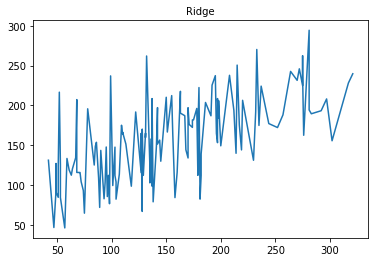

In [0]:
regridge(0)

k = 0.1

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.2271
- MSE = 3050.0324
- R2 = 0.4021

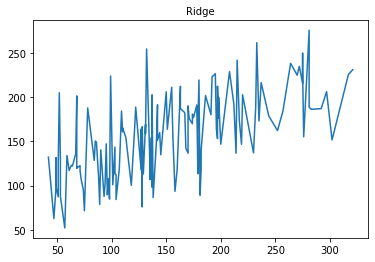

In [0]:
regridge(0.1)

k = 0.2

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.0152
- MSE = 3026.6677
- R2 = 0.4067

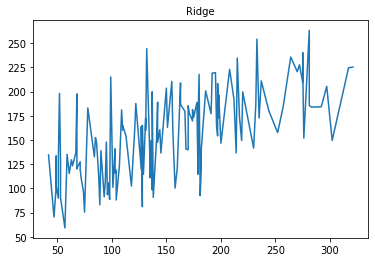

In [0]:
regridge(0.2)

k = 0.3

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.0521
- MSE = 3030.7343
- R2 = 0.4059

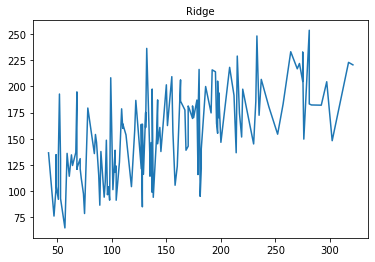

In [0]:
regridge(0.3)

k = 0.4

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.2201
- MSE = 3049.2625
- R2 = 0.4023

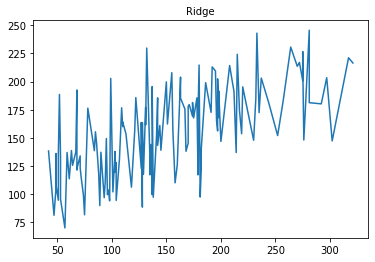

In [0]:
regridge(0.4)

k = 0.5

Test Size = 0.3
Numbers of obs for the Training dataset = 309
Number of obs for the Testing dataset = 133

- RMSE = 55.4578
- MSE = 3075.5727
- R2 = 0.3971

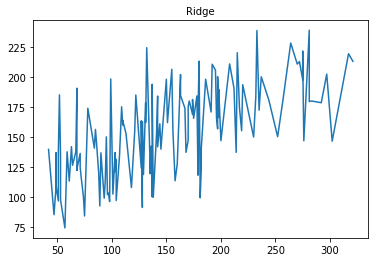

In [0]:
regridge(0.5)

In [0]:
%ls outputs/RegRidgeModele*.pkl -l

-rw-r--r-- 1 root root 628 Feb 10 14:01 outputs/RegRidgeModele-k-0.1.pkl
-rw-r--r-- 1 root root 628 Feb 10 14:01 outputs/RegRidgeModele-k-0.2.pkl
-rw-r--r-- 1 root root 628 Feb 10 14:01 outputs/RegRidgeModele-k-0.3.pkl
-rw-r--r-- 1 root root 628 Feb 10 14:01 outputs/RegRidgeModele-k-0.4.pkl
-rw-r--r-- 1 root root 628 Feb 10 14:05 outputs/RegRidgeModele-k-0.5.pkl
-rw-r--r-- 1 root root 621 Feb 10 14:01 outputs/RegRidgeModele-k-0.pkl

In [0]:
%ls RegRidgeGraphique*.png -l

-rw-r--r-- 1 root root 24471 Feb 10 14:01 RegRidgeGraphique-k-0.1.png
-rw-r--r-- 1 root root 26538 Feb 10 14:01 RegRidgeGraphique-k-0.2.png
-rw-r--r-- 1 root root 26890 Feb 10 14:01 RegRidgeGraphique-k-0.3.png
-rw-r--r-- 1 root root 27243 Feb 10 14:01 RegRidgeGraphique-k-0.4.png
-rw-r--r-- 1 root root 27150 Feb 10 14:05 RegRidgeGraphique-k-0.5.png
-rw-r--r-- 1 root root 25004 Feb 10 14:01 RegRidgeGraphique-k-0.png

## Let's save the best model into the model repository. All models are versioned.

Best model is for k=0.2

In [0]:
mymodel='RegRidgeModele-k-0.2.pkl'
k=0.2

RMSE = 55.0152
MSE = 3026.6677
R2 = 0.4067

> Let's register the best model into the Azure ML model repository

In [0]:
from azureml.core.model import Model

model = Model.register(model_path="outputs/"+mymodel, 
                       model_name="DiabetesRidge", 
                       model_framework=Model.Framework.SCIKITLEARN, 
                       model_framework_version='0.22.2',            
                       tags={'area': 'Diabetes', 
                             'type': 'Ridge', 
                             'k':k, 
                             'MSE' : MSE, 
                             'R2' : R2,
                             'RMSE' : RMSE,
                             'Databricks' : 'Yes',
                             'Framework' : 'Azure ML SDK from Azure Databricks'},
                       description="My regression model",
                       workspace=ws) 

Registering model DiabetesRidge

## Saved model informations:

In [0]:
print('Name :', model.name)
print('Description :', model.description)
print('ID =', model.id)
print('Version =', model.version)

Name : DiabetesRidge
Description : My regression model
ID = DiabetesRidge:46
Version = 46

Now we can see the model into the **Models** section in the **Azure ML Studio interface**:

In [0]:
experiment

Out[29]:

Name,Workspace,Report Page,Docs Page
Databricks-experiment,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation
